In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import hamming_loss, f1_score
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import itertools
from statistics import mean

In [2]:
papers_and_authors = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/added_features_data.csv')
papers_and_authors.head()

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264,0,0,0,1
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264,0,0,0,1
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807,0,0,0,1
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861,0,0,0,1
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861,0,0,0,1


In [3]:
top_authors = papers_and_authors.groupby(by='author_id')['paper_id'].count().sort_values(ascending=False).to_frame()
top_authors.reset_index(inplace=True)
top_authors.rename(columns={"paper_id":"paper_count"}, inplace=True)
top_authors.head()

,author_id,paper_count
0,330,101
1,1472,62
2,178,60
3,121,58
4,1020,51


In [4]:
top_authors_list = [330, 1472, 178, 121, 1020]

In [5]:
top_papers = papers_and_authors[papers_and_authors['author_id'].isin(top_authors_list)]
top_papers_duplicates = top_papers[top_papers.duplicated(subset='paper_id', keep=False)]
top_papers_duplicates.sort_values(by='paper_id')

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown
20270,1993,Supervised learning from incomplete\ndata via ...,767,330,59,20948,5.151910,0,0,0,1
20269,1993,Supervised learning from incomplete\ndata via ...,767,1020,59,20948,5.151910,0,0,0,1
20610,1994,An Alternative Model for Mixtures of\nExperts\...,906,121,44,17802,4.856669,0,0,0,1
20609,1994,An Alternative Model for Mixtures of\nExperts\...,906,330,44,17802,4.856669,0,0,0,1
20618,1994,Forward dynamic models in human\nmotor control...,909,330,70,19430,5.095964,0,0,0,1
20617,1994,Forward dynamic models in human\nmotor control...,909,1020,70,19430,5.095964,0,0,0,1
20705,1994,Computational structure of coordinate\ntransfo...,948,330,77,21404,5.326837,0,0,0,1
20703,1994,Computational structure of coordinate\ntransfo...,948,1020,77,21404,5.326837,0,0,0,1
40,1994,Active Learning with Statistical Models\n\nDav...,1011,1020,39,15512,5.052153,0,0,0,1
41,1994,Active Learning with Statistical Models\n\nDav...,1011,330,39,15512,5.052153,0,0,0,1


In [6]:
dummies = pd.get_dummies(papers_and_authors, columns=['author_id'])
dummies.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,...,author_id_10473,author_id_10474,author_id_10475,author_id_10476,author_id_10477,author_id_10478,author_id_10479,author_id_10480,author_id_10481,author_id_10482
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,62,21643,4.808264,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,62,21643,4.808264,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,98,15505,4.886807,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,116,20523,5.784861,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,116,20523,5.784861,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
agg_functions = {}

keys = dummies.columns
for i in keys:
    if re.match('author_id_\d*', i) == None:
        agg_functions[i] = 'first'
    else:
        agg_functions[i] = 'sum'

agg_functions

{'year': 'first',
 'paper_text': 'first',
 'paper_id': 'first',
 'title_len': 'first',
 'paper_len': 'first',
 'avg_word_len': 'first',
 'Oral': 'first',
 'Poster': 'first',
 'Spotlight': 'first',
 'Unknown': 'first',
 'author_id_1': 'sum',
 'author_id_2': 'sum',
 'author_id_3': 'sum',
 'author_id_4': 'sum',
 'author_id_5': 'sum',
 'author_id_6': 'sum',
 'author_id_7': 'sum',
 'author_id_8': 'sum',
 'author_id_9': 'sum',
 'author_id_10': 'sum',
 'author_id_11': 'sum',
 'author_id_12': 'sum',
 'author_id_13': 'sum',
 'author_id_14': 'sum',
 'author_id_15': 'sum',
 'author_id_16': 'sum',
 'author_id_17': 'sum',
 'author_id_18': 'sum',
 'author_id_19': 'sum',
 'author_id_20': 'sum',
 'author_id_21': 'sum',
 'author_id_22': 'sum',
 'author_id_23': 'sum',
 'author_id_24': 'sum',
 'author_id_25': 'sum',
 'author_id_26': 'sum',
 'author_id_27': 'sum',
 'author_id_28': 'sum',
 'author_id_29': 'sum',
 'author_id_30': 'sum',
 'author_id_31': 'sum',
 'author_id_32': 'sum',
 'author_id_33': 'sum',

In [8]:
df = dummies.groupby(dummies['paper_id']).aggregate(agg_functions).reset_index(drop=True)
df

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,...,author_id_10473,author_id_10474,author_id_10475,author_id_10476,author_id_10477,author_id_10478,author_id_10479,author_id_10480,author_id_10481,author_id_10482
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,62,21643,4.808264,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1987,184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...,2,61,16755,4.639499,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1987,52\n\nSupervised Learning of Probability Distr...,3,67,13400,4.984227,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1987,612\n\nConstrained Differential Optimization\n...,4,37,25759,5.013431,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1987,485\n\nTOWARDS AN ORGANIZING PRINCIPLE FOR\nA ...,5,64,32874,5.024413,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7234,2017,"On Separability of Loss Functions, and Revisit...",7280,85,34859,4.725678,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7235,2017,Maxing and Ranking with Few Assumptions\nMoein...,7281,39,36243,4.415865,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7236,2017,On clustering network-valued data\n\nSoumendu ...,7282,33,36121,4.940303,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7237,2017,A General Framework for Robust Interactive\nLe...,7283,51,40083,4.772216,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X=None; y=None; tested_authors_str=None

def X_y_generator(tested_authors):

    """A function to take the dataframe df and create X (features) and y (target features) for a given
    list of authors 'tested_authors' to include in y. It also scales the features in X so they are usable 
    by the Logistic Regression model"""

    global X; global y; global df; global tested_authors_str

    tested_authors_str = []
    for author in tested_authors:
        tested_authors_str.append(f'author_id_{author}')
    
    exclude = tested_authors_str.__add__(['paper_id'])

    X = df[df.columns.difference(exclude)]

    y = df[tested_authors_str]

    scaled_feat = X[X.columns.difference(['paper_text'])]
    paper_text = pd.DataFrame(X.paper_text)

    minmax = MinMaxScaler()
    scaled_feat = pd.DataFrame(minmax.fit_transform(scaled_feat), columns=scaled_feat.columns)
    X = scaled_feat.join(paper_text)

In [10]:
tested_authors = [330, 1020]
X_y_generator(tested_authors=tested_authors)

In [11]:
X_train = None
X_test = None
y_train = None
y_test = None

def vector_train_test(X, y, rand_state, stratify): 

    """A function that takes two arrays X and y and splits them into a train and test set.
    It also vectorizes the text input with TfidfVectorizer, and sets the global variables
    X_train, X_test, y_train, y_test to the relevant sparse matrices"""

    global X_train; global X_test; global y_train; global y_test
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, train_size=0.75, stratify=stratify)

    other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
    other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

    tfidf = TfidfVectorizer()

    X_train_vector = tfidf.fit_transform(X_train.paper_text)
    X_test_vector = tfidf.transform(X_test.paper_text)

    X_train = hstack([other_features_train, X_train_vector])
    X_test = hstack([other_features_test, X_test_vector])

    X_train = np.asarray(csr_matrix.todense(X_train))
    X_test = np.asarray(csr_matrix.todense(X_test))
    y_train = pd.DataFrame.to_numpy(y_train)
    y_test = pd.DataFrame.to_numpy(y_test)


In [12]:
vector_train_test(X=X, y=y, rand_state=11, stratify=y)

In [13]:
LR = LogisticRegression(C=1, max_iter=1000, class_weight='balanced')

multi_output_LR = MultiOutputClassifier(LR)
multi_output_LR.fit(X_train, y_train)

prediction = multi_output_LR.predict(X_test)

In [14]:
h_loss = hamming_loss(y_test, prediction)
f_score = f1_score(y_test, prediction, average='weighted')
print('Hamming loss is:', h_loss)
print('F1 score is:', f_score)

Hamming loss is: 0.016574585635359115
F1 score is: 0.37168603891863655


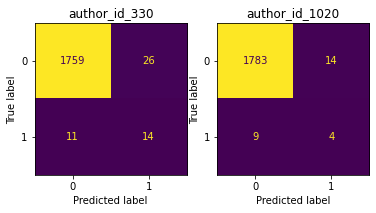

In [15]:
c_matricies_test = multilabel_confusion_matrix(y_test, prediction)
fig, ax = plt.subplots(1, 2)
for i, cm_test in enumerate(c_matricies_test):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp.plot(ax=ax[i])
    disp.ax_.set_title(f'{tested_authors_str[i]}')
    disp.im_.colorbar.remove()
plt.show()

In [16]:
proba = multi_output_LR.predict_proba(X_test)

proba

[array([[0.95828328, 0.04171672],
        [0.92313038, 0.07686962],
        [0.98882745, 0.01117255],
        ...,
        [0.96156796, 0.03843204],
        [0.95457265, 0.04542735],
        [0.97013984, 0.02986016]]),
 array([[0.96944742, 0.03055258],
        [0.98308021, 0.01691979],
        [0.99390663, 0.00609337],
        ...,
        [0.97042894, 0.02957106],
        [0.72529134, 0.27470866],
        [0.96058439, 0.03941561]])]

In [17]:
proba_df = pd.DataFrame(data=[proba[0][:, 1], proba[1][:, 1]], index=tested_authors_str).T
proba_df

,author_id_330,author_id_1020
0,0.041717,0.030553
1,0.076870,0.016920
2,0.011173,0.006093
3,0.051007,0.075532
4,0.186474,0.075815
...,...,...
1805,0.037872,0.024095
1806,0.050734,0.019300
1807,0.038432,0.029571
1808,0.045427,0.274709


In [18]:
proba_df['True_Label_list'] = y_test.tolist()
proba_df['True_Label'] = [','.join(map(str, l)) for l in proba_df['True_Label_list']]
proba_df.drop('True_Label_list', axis=1, inplace=True)
proba_df

,author_id_330,author_id_1020,True_Label
0,0.041717,0.030553,"0,0"
1,0.076870,0.016920,"0,0"
2,0.011173,0.006093,"0,0"
3,0.051007,0.075532,"0,0"
4,0.186474,0.075815,"0,0"
...,...,...,...
1805,0.037872,0.024095,"0,0"
1806,0.050734,0.019300,"0,0"
1807,0.038432,0.029571,"0,0"
1808,0.045427,0.274709,"0,1"


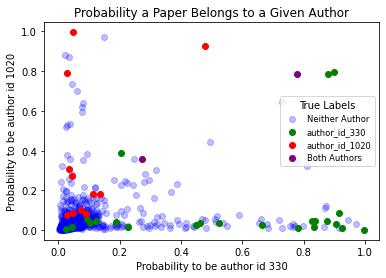

In [19]:
plt.scatter(x=proba_df['author_id_330'][proba_df['True_Label']=='0,0'], y=proba_df['author_id_1020'][proba_df['True_Label']=='0,0'], color='blue', alpha=0.25, label='Neither Author')
plt.scatter(x=proba_df['author_id_330'][proba_df['True_Label']=='1,0'], y=proba_df['author_id_1020'][proba_df['True_Label']=='1,0'], color='green', label='author_id_330')
plt.scatter(x=proba_df['author_id_330'][proba_df['True_Label']=='0,1'], y=proba_df['author_id_1020'][proba_df['True_Label']=='0,1'], color='red', label='author_id_1020')
plt.scatter(x=proba_df['author_id_330'][proba_df['True_Label']=='1,1'], y=proba_df['author_id_1020'][proba_df['True_Label']=='1,1'], color='purple', label='Both Authors')
plt.title('Probability a Paper Belongs to a Given Author')
plt.xlabel('Probability to be author id 330')
plt.ylabel('Probability to be author id 1020')
plt.legend(title='True Labels', fontsize='small', loc=5)
plt.show()

MultiOutputClassifier

In [20]:
five_authors = top_authors.author_id[0:5].to_list()

ten_authors = top_authors.author_id[0:10].to_list()

fifteen_authors = top_authors.author_id[0:15].to_list()

five_authors

[330, 1472, 178, 121, 1020]

In [21]:
authors_list_of_lists = [five_authors, ten_authors, fifteen_authors]

In [22]:
random_states = [0, 1, 2, 3, 4]

In [23]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
MOC_dict = {'Num_authors_tested' : [],
            'F1_score_train_avg': [],
            'F1_score_test_avg':[]}

run = 0

for auth_list in authors_list_of_lists:

    # Appending the # of authors tested to the dictionary
    MOC_dict['Num_authors_tested'].append(len(auth_list))

    # Creating the X and y feature variables to be used for this set of authors
    X_y_generator(tested_authors=auth_list)

    F1_train_scores = []
    F1_test_scores = []

    for random_state in random_states:

        # Counting what iteration I am on
        print(run)
        run += 1

        # Generating X_train, X_test, y_train, y_test
        vector_train_test(X=X, y=y, rand_state=random_state, stratify=None)

        # Creating the MOC-LR model, fitting it on the train set
        LR = LogisticRegression(C=1, max_iter=1000, class_weight='balanced')

        multi_output_LR = MultiOutputClassifier(LR)
        multi_output_LR.fit(X_train, y_train)

        # Predicting on the train and test sets
        pred_train = multi_output_LR.predict(X_train)
        pred_test = multi_output_LR.predict(X_test)
        
        # Finding the average f1_score for this iteration
        f_score_train = f1_score(y_train, pred_train, average='weighted')
        f_score_test = f1_score(y_test, pred_test, average='weighted')

        # Appending this score to the list outside of the loop
        F1_train_scores.append(f_score_train)
        F1_test_scores.append(f_score_test)

    # Appending the scores to the dictionary
    MOC_dict['F1_score_train_avg'].append(mean(F1_train_scores))
    MOC_dict['F1_score_test_avg'].append(mean(F1_test_scores))


0


KeyboardInterrupt: 

In [ ]:
MOC_HPtable = pd.DataFrame.from_dict(MOC_dict)
MOC_HPtable.sort_values(by='F1_score_test_avg', ascending=False, inplace=True)
MOC_HPtable

,Num_authors_tested,F1_score_train_avg,F1_score_test_avg
1,10,0.809592,0.464702
2,15,0.825318,0.456004
0,5,0.789369,0.430158


In [31]:
authors_list_of_lists = [five_authors, ten_authors, fifteen_authors]

In [32]:
random_states = [0, 1, 2, 3, 4]

In [33]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
CC_dict = {'Num_authors_tested' : [],
            'F1_score_train_avg': [],
            'F1_score_test_avg':[]}

run = 0

for auth_list in authors_list_of_lists:

    # Appending the # of authors tested to the dictionary
    CC_dict['Num_authors_tested'].append(len(auth_list))

    # Creating the X and y feature variables to be used for this set of authors
    X_y_generator(tested_authors=auth_list)

    F1_train_scores = []
    F1_test_scores = []

    for random_state in random_states:

        # Counting what iteration I am on
        print(run)
        run += 1

        # Generating X_train, X_test, y_train, y_test
        vector_train_test(X=X, y=y, rand_state=random_state, stratify=None)

        # Creating the MOC-LR model, fitting it on the train set
        LR = LogisticRegression(C=1, max_iter=1000, class_weight='balanced')

        chain = ClassifierChain(LR, order='random', random_state=random_state)
        multi_output_LR.fit(X_train, y_train)

        # Predicting on the train and test sets
        pred_train = multi_output_LR.predict(X_train)
        pred_test = multi_output_LR.predict(X_test)
        
        # Finding the average f1_score for this iteration
        f_score_train = f1_score(y_train, pred_train, average='weighted')
        f_score_test = f1_score(y_test, pred_test, average='weighted')

        # Appending this score to the list outside of the loop
        F1_train_scores.append(f_score_train)
        F1_test_scores.append(f_score_test)

    # Appending the scores to the dictionary
    CC_dict['F1_score_train_avg'].append(mean(F1_train_scores))
    CC_dict['F1_score_test_avg'].append(mean(F1_test_scores))

0
1
2
3
4
5
6
7
8
9


In [34]:
CC_HPtable = pd.DataFrame.from_dict(CC_dict)
CC_HPtable.sort_values(by='F1_score_test_avg', ascending=False, inplace=True)
CC_HPtable

,Num_authors_tested,F1_score_train_avg,F1_score_test_avg
1,10,0.809592,0.464702
0,5,0.789369,0.430158
